In [2]:
import pandas as pd
import seaborn as se
import pickle
from collections import Counter
import numpy as np
import os
import pickle
from timeit import timeit
import json
from timeit import default_timer as timer
from pathlib import Path
import shutil
import math
import matplotlib.pyplot as plt
from math import sqrt, prod
from tqdm import tqdm
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
from config import arch_config
import logging
logging.getLogger('matplotlib').setLevel(logging.ERROR)


In [15]:
se.set_style("darkgrid")

PE Utilization    45.04303
dtype: float64

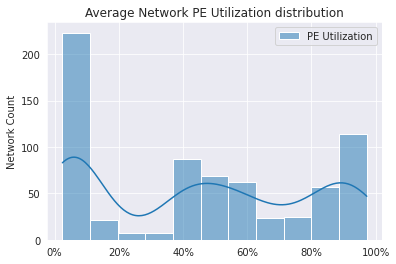

In [16]:
arch_metrics = pd.read_csv('../data/arch_metrics_iofmap_1mb.csv', index_col=[0,1],)

util = arch_metrics.groupby(level = 0).mean().loc[:, arch_metrics.columns.isin(['util'])].mul(100)
util = util.rename(columns={"util": "PE Utilization"})
plt = se.histplot(data = util, kde=True)
plt.xaxis.set_major_formatter(mtick.PercentFormatter())
plt.set_ylabel('Network Count')
plt.set_title('Average Network PE Utilization distribution')
util.mean()

Text(0.5, 1.0, 'Average Layer PE Utilization')

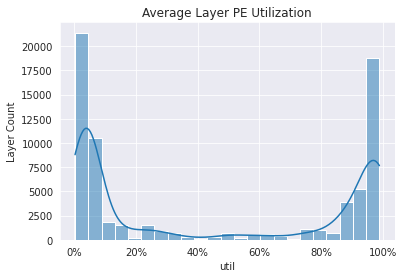

In [17]:
arch_metrics = pd.read_csv('../data/arch_metrics_iofmap_1mb.csv', index_col=[0,1],)

plt = se.histplot(data = arch_metrics['util'].mul(100), kde=True)
plt.xaxis.set_major_formatter(mtick.PercentFormatter())
plt.set_ylabel('Layer Count')
plt.set_title('Average Layer PE Utilization')

/tmp/ipykernel_148413/720191443.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.ax_marg_x.set_xticklabels([r'$10^{'+str(i)+'}$' for i in plt.ax_marg_x.get_xticks()])
/tmp/ipykernel_148413/720191443.py:59: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.ax_marg_x.set_xticklabels([r'$10^{'+str(i)+'}$' for i in plt.ax_marg_x.get_xticks()])


Text(0.5, -0.2, 'Contour Plot of Avg. Network PE Utilization & Avg. Network Latency')

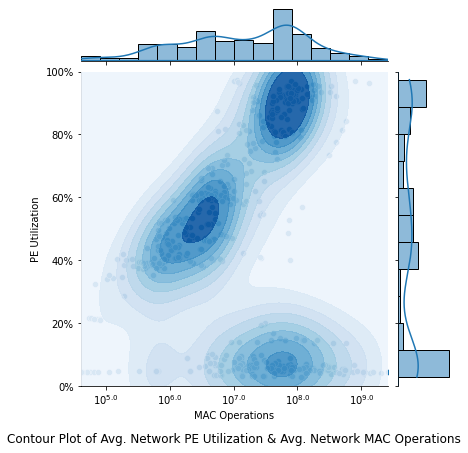

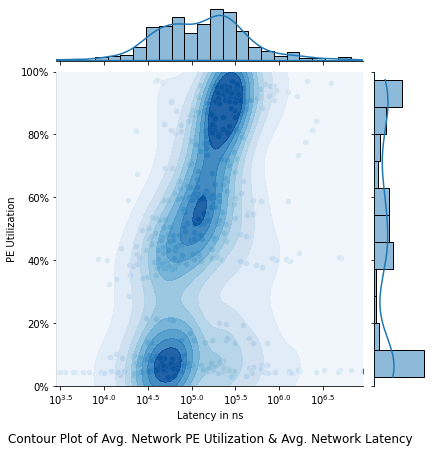

In [3]:
layer_metrics = pd.read_csv('../data/layer_metrics.csv', index_col=[0, 1])
arch_metrics = pd.read_csv('../data/arch_metrics_iofmap_2mb.csv', index_col=[0,1],)

util = arch_metrics.groupby(level = 0).mean().loc[:, arch_metrics.columns.isin(['util'])].mul(100)
layer_metrics['macs'] = np.log10(layer_metrics['macs'])
macs_vs_util_df = pd.DataFrame(layer_metrics['macs'].groupby(level=0).mean()).join(util)

plt = se.jointplot(
    data=macs_vs_util_df,
    x="macs",
    y="util",
    kind="kde",
    cmap="Blues",
    zorder=5,
    levels=10,
    alpha=0.9,
    shade=True,
    thresh=0,
    ylim=(0, 100),
    xlim=(
        macs_vs_util_df[["macs"]].min().item(),
        macs_vs_util_df[["macs"]].max().item(),
    ),
)
plt.plot_joint(se.scatterplot)
plt.plot_marginals(se.histplot, zorder=0, kde=True)
plt.ax_marg_y.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.ax_marg_x.set_xticklabels([r'$10^{'+str(i)+'}$' for i in plt.ax_marg_x.get_xticks()])
plt.ax_joint.set_ylabel('PE Utilization')
plt.ax_joint.set_xlabel('MAC Operations')
plt.ax_joint.set_title('Contour Plot of Avg. Network PE Utilization & Avg. Network MAC Operations', y = -0.2)



latency = arch_metrics[['latency']].groupby(level=0).mean()
latency = np.log10(latency)
latency_vs_util = latency.join(arch_metrics[['util']].groupby(level=0).mean().mul(100))

plt = se.jointplot(
    data=latency_vs_util,
    x="latency",
    y="util",
    kind="kde",
    cmap="Blues",
    zorder=5,
    levels=10,
    alpha=0.9,
    shade=True,
    thresh=0,
    ylim=(0, 100),
    xlim=(
        latency_vs_util[["latency"]].min().item(),
        latency_vs_util[["latency"]].max().item(),
    ),
)
plt.plot_joint(se.scatterplot)
plt.plot_marginals(se.histplot, zorder=0, kde=True)
plt.ax_marg_y.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.ax_marg_x.set_xticklabels([r'$10^{'+str(i)+'}$' for i in plt.ax_marg_x.get_xticks()])
plt.ax_joint.set_ylabel('PE Utilization')
plt.ax_joint.set_xlabel('Latency in ns')
plt.ax_joint.set_title('Contour Plot of Avg. Network PE Utilization & Avg. Network Latency', y = -0.2)


/tmp/ipykernel_228166/2045303386.py:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.ax_marg_x.set_xticklabels(
/tmp/ipykernel_228166/2045303386.py:76: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.ax_marg_x.set_xticklabels(


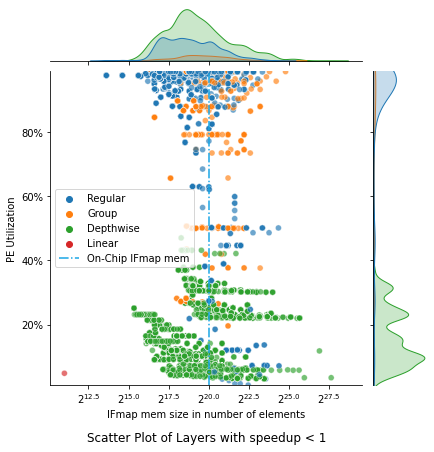

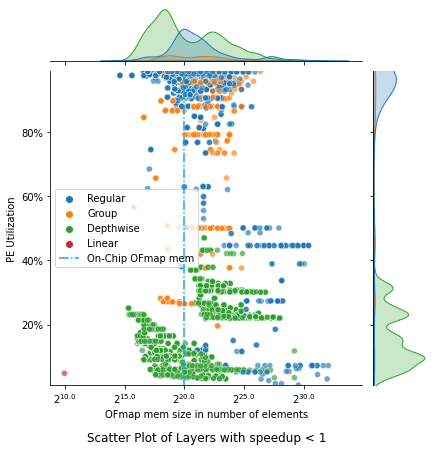

In [5]:
arch_metrics = pd.read_csv(
    "../data/arch_metrics_iofmap_1mb.csv",
    index_col=[0, 1],
)
layer_properties = pd.read_csv("../data/layer_metrics.csv", index_col=[0, 1])
speedup_ub = 1
slow_layers = arch_metrics[arch_metrics["speedup"] < speedup_ub].join(layer_properties)
slow_layers["total_mem_size"] = pd.DataFrame(
    np.log2(slow_layers["ifmap_mem_size"] + slow_layers["ofmap_mem_size"])
)
slow_layers["ifmap_mem"] = pd.DataFrame(np.log2(slow_layers["ifmap_mem_size"]))
slow_layers["ofmap_mem"] = pd.DataFrame(np.log2(slow_layers["ofmap_mem_size"]))
slow_layers["util"] = arch_metrics["util"].mul(100)

slow_layers["Layer Type"] = "Undefined"

depthwise_layers = slow_layers[(slow_layers["groups"] == slow_layers["channels"])]
slow_layers.loc[
    slow_layers.index.isin(depthwise_layers.index), "Layer Type"
] = "Depthwise"

grouped_conv_layers = slow_layers[
    (slow_layers["groups"] != slow_layers["channels"]) & (slow_layers["groups"] > 1)
]
slow_layers.loc[
    slow_layers.index.isin(grouped_conv_layers.index), "Layer Type"
] = "Group"

regular_conv = slow_layers[slow_layers["groups"] == 1]
slow_layers.loc[slow_layers.index.isin(regular_conv.index), "Layer Type"] = "Regular"

non_conv_layers = slow_layers[slow_layers["type"] != "conv"]
slow_layers.loc[slow_layers.index.isin(non_conv_layers.index), "Layer Type"] = "Linear"

plt = se.jointplot(
    data=slow_layers,
    x="ifmap_mem",
    y="util",
    kind="scatter",
    cmap="Blues",
    alpha=0.65,
    ylim=(
        slow_layers[["util"]].min().item(),
        slow_layers[["util"]].max().item(),
    ),
    hue="Layer Type",
)
# plt.plot_marginals(se.histplot, zorder=1, kde=True)
plt.ax_marg_y.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.ax_marg_x.set_xticklabels(
    [r"$2^{" + str(i) + "}$" for i in plt.ax_marg_x.get_xticks()]
)
plt.ax_joint.set_ylabel("PE Utilization")
plt.ax_joint.set_xlabel("IFmap mem size in number of elements")
plt.ax_joint.set_title("Scatter Plot of Layers with speedup < 1", y=-0.2)
plt.ax_joint.axvline(
    x=np.log2(arch_config["ifmap_mem_ub"]), color="#18A5E5", alpha=1, linestyle="-.", zorder=10, label="On-Chip IFmap mem"
)
plt.ax_joint.legend()

plt = se.jointplot(
    data=slow_layers,
    x="ofmap_mem",
    y="util",
    kind="scatter",
    cmap="Blues",
    alpha=0.65,
    ylim=(
        slow_layers[["util"]].min().item(),
        slow_layers[["util"]].max().item(),
    ),
    hue="Layer Type",
)
# plt.plot_marginals(se.distplot, zorder=1, kde=True)
plt.ax_marg_y.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.ax_marg_x.set_xticklabels(
    [r"$2^{" + str(i) + "}$" for i in plt.ax_marg_x.get_xticks()]
)
plt.ax_joint.set_ylabel("PE Utilization")
plt.ax_joint.set_xlabel("OFmap mem size in number of elements")
plt.ax_joint.set_title(f"Scatter Plot of Layers with speedup < {speedup_ub}", y=-0.2)
plt.ax_joint.axvline(
    x=20, color="#18A5E5", alpha=1, linestyle="-.", zorder=10, label="On-Chip OFmap mem"
)
plt.ax_joint.legend()


/tmp/ipykernel_148413/2537425002.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  slow_layers = arch_metrics[


Text(0.5, -0.45, 'Types of layers with\nspeedup < 1\nutilization < 0.5\nmemory footprint < $2^{20}$ elements')

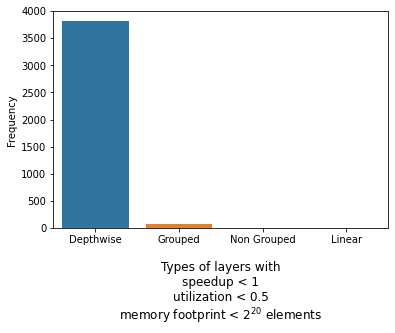

In [5]:
arch_metrics = pd.read_csv(
    "../data/arch_metrics_iofmap_1mb.csv",
    index_col=[0, 1],
)
layer_properties = pd.read_csv("../data/layer_metrics.csv", index_col=[0, 1])
speedup_ub = 1
util_ub = 0.5
slow_layers = arch_metrics[
    (arch_metrics["speedup"] < speedup_ub)
    & (layer_properties["ifmap_mem_size"] < 2**20)
    & (layer_properties["ofmap_mem_size"] < 2**20)
    & (arch_metrics["util"] < util_ub)
].join(layer_properties)

slow_layers["Layer Type"] = "Undefined"

depthwise_layers = slow_layers[(slow_layers["groups"] == slow_layers["channels"])]
slow_layers.loc[
    slow_layers.index.isin(depthwise_layers.index), "Layer Type"
] = "Depthwise"

grouped_conv_layers = slow_layers[
    (slow_layers["groups"] != slow_layers["channels"]) & (slow_layers["groups"] > 1)
]
slow_layers.loc[
    slow_layers.index.isin(grouped_conv_layers.index), "Layer Type"
] = "Group"

regular_conv = slow_layers[slow_layers["groups"] == 1]
slow_layers.loc[slow_layers.index.isin(regular_conv.index), "Layer Type"] = "Regular"

non_conv_layers = slow_layers[slow_layers["type"] != "conv"]
slow_layers.loc[slow_layers.index.isin(non_conv_layers.index), "Layer Type"] = "Linear"

counts = pd.DataFrame(
    {
        "": ["Depthwise", "Grouped", "Non Grouped", "Linear"],
        "Frequency": [
            len(depthwise_layers),
            len(grouped_conv_layers),
            len(regular_conv),
            len(non_conv_layers),
        ],
    }
)
plt = se.barplot(data=counts, x="", y="Frequency")
plt.set_title(
    "Types of layers with\nspeedup < 1\n" + "utilization < " + str(util_ub) + '\n' + r"memory footprint < $2^{20}$ elements" , y=-0.45
)

/tmp/ipykernel_148413/3875002404.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  slow_layers_with_low_util_and_large_footprint = arch_metrics[


Text(0.5, -0.55, 'Reason for low utilization in layers with:\n speedup < 1\nutilization < 0.85\nmemory footprint > $2^{20}$ elements')

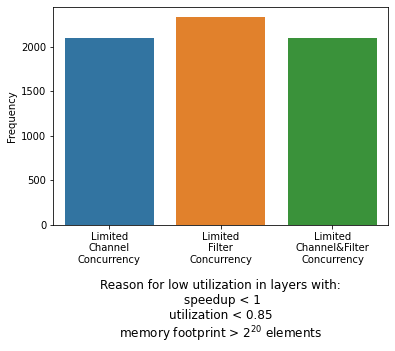

In [6]:
arch_metrics = pd.read_csv(
    "../data/arch_metrics_iofmap_1mb.csv",
    index_col=[0, 1],
)
layer_properties = pd.read_csv("../data/layer_metrics.csv", index_col=[0, 1])
speedup_ub = 1
util_ub = 0.85
slow_layers_with_low_util_and_large_footprint = arch_metrics[
    (arch_metrics["speedup"] < speedup_ub)
    & (arch_metrics["util"] < util_ub)
    & (
        (layer_properties["ifmap_mem_size"] > 2**20)
        | (layer_properties["ofmap_mem_size"] > 2**20)
    )
].join(layer_properties)

single_ifmap_size = (
    slow_layers_with_low_util_and_large_footprint["ifmap_mem_size"]
) / (
    slow_layers_with_low_util_and_large_footprint["in_channels"]
    / slow_layers_with_low_util_and_large_footprint["groups"]
)

single_ofmap_size = (
    slow_layers_with_low_util_and_large_footprint["ofmap_mem_size"]
) / (
    slow_layers_with_low_util_and_large_footprint["out_channels"]
    / slow_layers_with_low_util_and_large_footprint["groups"]
)

slow_layers_with_low_util_and_large_footprint.loc[
    ~slow_layers_with_low_util_and_large_footprint["kernel_size"].isin(
        ["(1, 1)", "(3, 3)"]
    ),
    "kernel_size",
] = "(1, 1)"

ceff = 18 / slow_layers_with_low_util_and_large_footprint["kernel_size"].apply(
    func=lambda x: prod(map(int, x[1:-1].split(",")))
)

max_concurrent_channels = 2**20 / single_ifmap_size
(max_concurrent_channels < ceff).value_counts()

feff = 32
max_concurrent_filters = 2**20 / single_ofmap_size
(max_concurrent_filters < feff).value_counts()

counts = pd.DataFrame(
    {
        "": [
            "Mem-Limited\nChannel\nConcurrency",
            "Mem-Limited\nFilter\nConcurrency",
            "Mem-Limited\nChannel&Filter\nConcurrency",
        ],
        "Frequency": [
            len(
                slow_layers_with_low_util_and_large_footprint[
                    ((max_concurrent_channels < ceff))
                ]
            ),
            len(
                slow_layers_with_low_util_and_large_footprint[
                    ((max_concurrent_filters < feff))
                ]
            ),
            len(
                slow_layers_with_low_util_and_large_footprint[
                    ((max_concurrent_filters < feff) & (max_concurrent_channels < ceff))
                ]
            ),
        ],
    }
)

counts
plt = se.barplot(data=counts, x="", y="Frequency")
plt.set_title(
    "Reason for low utilization in layers with:\n speedup < 1\n" + "utilization < " + str(util_ub) +'\n' + r"memory footprint > $2^{20}$ elements", y=-0.55
)


/tmp/ipykernel_148413/3944696105.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  slow_layers_with_high_util = arch_metrics[
/tmp/ipykernel_148413/3944696105.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.set_xticklabels([f'{i}X' for i in plt.get_xticks()])


Text(0.5, 1.0, 'MAC Factor Increase For Lowered/Lifted Layers')

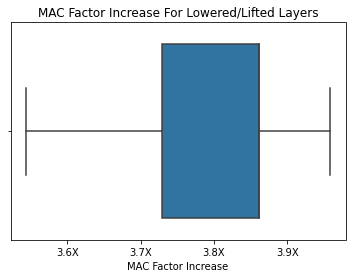

In [7]:
arch_metrics = pd.read_csv(
    "../data/arch_metrics_iofmap_1mb.csv",
    index_col=[0, 1],
)
layer_properties = pd.read_csv("../data/layer_metrics.csv", index_col=[0, 1])
speedup_ub = 1
util_lb = 0.5
slow_layers_with_high_util = arch_metrics[
    (arch_metrics["speedup"] < speedup_ub)
    & (arch_metrics["util"] > util_lb)
    & (layer_properties['lowered/lifted'] == True )
].join(layer_properties)

slow_layers_with_high_util['MAC Factor Increase'] = slow_layers_with_high_util['macs'] / slow_layers_with_high_util['original_macs']

plt = se.boxplot(data=slow_layers_with_high_util, x='MAC Factor Increase', showfliers = False)
plt.set_xticklabels([f'{i}X' for i in plt.get_xticks()])
plt.set_title('MAC Factor Increase For Lowered/Lifted Layers')

/tmp/ipykernel_148413/1252923035.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  slow_layers_with_high_util = arch_metrics[
/tmp/ipykernel_148413/1252923035.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.ax_marg_x.set_xticklabels(
/tmp/ipykernel_148413/1252923035.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.ax_marg_y.set_yticklabels(


Text(0.5, -0.3, 'Scatter Plot of Filter vs Channel Counts in Layers with \nutilization > 0.85 & speedup < 1')

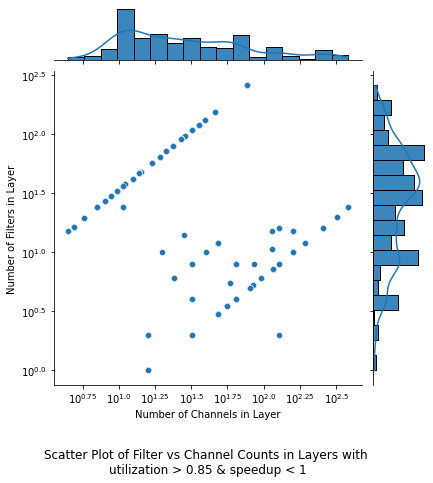

In [8]:
arch_metrics = pd.read_csv(
    "../data/arch_metrics_iofmap_1mb.csv",
    index_col=[0, 1],
)
layer_properties = pd.read_csv("../data/layer_metrics.csv", index_col=[0, 1])
speedup_ub = 1
util_lb = 0.85
slow_layers_with_high_util = arch_metrics[
    (arch_metrics["speedup"] < speedup_ub)
    & (arch_metrics["util"] > util_lb)
    & (layer_properties["lowered/lifted"] == False)
].join(layer_properties)
ceff = 18 / slow_layers_with_high_util["kernel_size"].apply(
    func=lambda x: prod(map(int, x[1:-1].split(",")))
)
feff = 32
slow_layers_with_high_util["in_channels"] = np.log10(
    (slow_layers_with_high_util["in_channels"] / slow_layers_with_high_util["groups"])
    / ceff
)
slow_layers_with_high_util["out_channels"] = np.log10(
    (slow_layers_with_high_util["out_channels"] / slow_layers_with_high_util["groups"])
    / feff
)
plt = se.jointplot(data=slow_layers_with_high_util, x="in_channels", y="out_channels")
plt.ax_marg_x.set_xticklabels(
    [r"$10^{" + str(i) + "}$" for i in plt.ax_marg_x.get_xticks()]
)
plt.ax_marg_y.set_yticklabels(
    [r"$10^{" + str(i) + "}$" for i in plt.ax_marg_y.get_yticks()]
)
plt.plot_marginals(se.histplot, zorder=0, kde=True)
plt.ax_joint.set_ylabel("Number of Filters in Layer")
plt.ax_joint.set_xlabel("Number of Channels in Layer")
plt.ax_joint.set_title(
    f"Scatter Plot of Filter vs Channel Counts in Layers with \nutilization > {util_lb} & speedup < {speedup_ub}",
    y=-0.3,
)


/tmp/ipykernel_148413/755341681.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  arch_metrics[
/tmp/ipykernel_148413/755341681.py:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  arch_metrics[
/tmp/ipykernel_148413/755341681.py:36: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  arch_metrics[
/tmp/ipykernel_148413/755341681.py:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  arch_metrics[


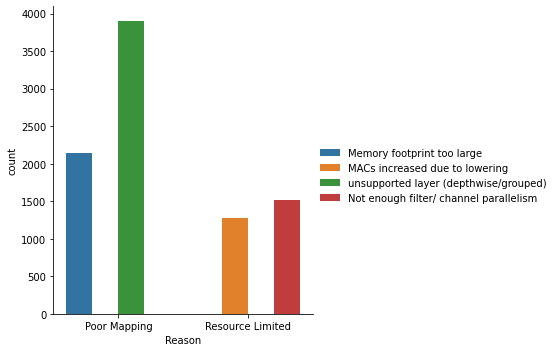

In [9]:
arch_metrics = pd.read_csv(
    "../data/arch_metrics_iofmap_1mb.csv",
    index_col=[0, 1],
)
layer_metrics = pd.read_csv(
    "../data/layer_metrics.csv",
    index_col=[0, 1],
)
slow_layers = len(
    arch_metrics[
        (arch_metrics["speedup"] < speedup_ub)
    ]
)
util_b = 0.5
slow_layers_with_low_util_and_small_footprint = len(
    arch_metrics[
        (arch_metrics["speedup"] < speedup_ub)
        & (layer_properties["ifmap_mem_size"] < 2**20)
        & (layer_properties["ofmap_mem_size"] < 2**20)
        & (arch_metrics["util"] < util_b)
    ]
)

slow_layers_with_low_util_and_large_footprint = len(
    arch_metrics[
        (arch_metrics["speedup"] < speedup_ub)
        & (arch_metrics["util"] < util_b)
        & (
            (layer_properties["ifmap_mem_size"] > 2**20)
            | (layer_properties["ofmap_mem_size"] > 2**20)
        )
    ]
)

slow_layers_with_high_util_with_extra_macs = len(
    arch_metrics[
        (arch_metrics["speedup"] < speedup_ub)
        & (arch_metrics["util"] > util_b)
        & (layer_properties["lowered/lifted"] == True)
    ]
)
slow_layers_with_high_util_with_no_extra_macs = len(
    arch_metrics[
        (arch_metrics["speedup"] < speedup_ub)
        & (arch_metrics["util"] > util_b)
        & (layer_properties["lowered/lifted"] == False)
    ]
)
counts = pd.DataFrame.from_records(
    [
        {
            "Reason": "Poor Mapping",
            "": "Memory footprint too large",
            "count": slow_layers_with_low_util_and_large_footprint,
        },
        {
            "Reason": "Resource Limited",
            "": "MACs increased due to lowering",
            "count": slow_layers_with_high_util_with_extra_macs,
        },
        {
            "Reason": "Poor Mapping",
            "": "unsupported layer (depthwise/grouped)",
            "count": slow_layers_with_low_util_and_small_footprint,
        },        {
            "Reason": "Resource Limited",
            "": "Not enough filter/ channel parallelism",
            "count": slow_layers_with_high_util_with_no_extra_macs,
        },
    ]
)
se.catplot(x="Reason", y="count", hue="", kind="bar", data=counts)
total = (
    slow_layers_with_low_util_and_small_footprint
    + slow_layers_with_low_util_and_large_footprint
    + slow_layers_with_high_util_with_extra_macs
    + slow_layers_with_high_util_with_no_extra_macs
)


In [25]:
slow_layers_with_low_util_and_small_footprint

5733